# Note book forthe Project:
# Don’t get stressed – 
# Study on Finding a perfect spot to open a Yoga Studio


## 1. Libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

 #Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib as plt
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


<a id='item1'></a>


## 2. Data set


### 2. 1 Loading the Data for New York


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.


In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [6]:
data = pd.read_json('nycneighborhoods.geojson')


In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.


In [8]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.


In [10]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Use geopy library to get the latitude and longitude values of New York City.


In [11]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.


In [12]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Queens.


In [13]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


visualize the neighborhoods in Manhattan.


Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.


## 2.2 Define Foursquare Credentials and Version


In [14]:
CLIENT_ID = 'SQ2IKAON1UJZ5YGNN1ML1QMIZXOOHRSIIBOC30ZAC5V5O5TF' # your Foursquare ID
CLIENT_SECRET = '3GFTIKTEY5SSN2AUBGSU0YJBNI5V5F4EZ0MVQBJCP3BRSJ0Y' # your Foursquare Secret
ACCESS_TOKEN = 'UNZAFVAKJQSIHL514EXKBDFQ24PNVGEHHKTUIP5RENH1U2NT' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SQ2IKAON1UJZ5YGNN1ML1QMIZXOOHRSIIBOC30ZAC5V5O5TF
CLIENT_SECRET:3GFTIKTEY5SSN2AUBGSU0YJBNI5V5F4EZ0MVQBJCP3BRSJ0Y


Get the neighborhood's name.


In [15]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.


In [16]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.


First, let's create the GET request URL. Name your URL **url**.


In [17]:
# type your answer here
search_query = ''
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url


'https://api.foursquare.com/v2/venues/explore?&client_id=SQ2IKAON1UJZ5YGNN1ML1QMIZXOOHRSIIBOC30ZAC5V5O5TF&client_secret=3GFTIKTEY5SSN2AUBGSU0YJBNI5V5F4EZ0MVQBJCP3BRSJ0Y&v=20180605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

Double-click **here** for the solution.

<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 


Send the GET request and examine the resutls


In [18]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6027b0ad9854e8099c21f23b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Marble Hill',
  'headerFullLocation': 'Marble Hill, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 24,
  'suggestedBounds': {'ne': {'lat': 40.88105078329964,
    'lng': -73.90471933917806},
   'sw': {'lat': 40.87205077429964, 'lng': -73.91659997808156}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4429abf964a52037f225e3',
       'name': "Arturo's",
       'location': {'address': '5198 Broadway',
        'crossStreet': 'at 225th St.',
        'lat': 40.87441177110231,
        'lng': -73.91027100981574,
        'labeledLatLngs': [{'label'

## 2.3 Get the population and Median Income Data

In [127]:
df_fin=pd.read_excel('Manhattan Population1.xls')
df_fin

,Neighborhood,Median Income,Population
0,Battery Park City,21638,10970
1,Carnegie Hill,122969,45225
2,Central Harlem,29059,116345
3,Chelsea,115556,48108
4,Chinatown,75086,12874
5,Civic Center,159882,5974
6,Clinton,103792,46648
7,East Harlem,33720,95589
8,East Village,90939,65101
9,Financial District,186231,27834


<a id='item2'></a>


### 2.3 Get the venues of Manhattan

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan


In [128]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _manhattan_venues_.


In [129]:
# type your answer here
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
manhattan_venues.shape

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


(3187, 7)

Double-click **here** for the solution.

<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 


#### Let's check the size of the resulting dataframe


### 2.4  Lets find the yoga venues

In [130]:
manhattan_venues['Venue Category'].unique()

array(['Pizza Place', 'Yoga Studio', 'Diner', 'Coffee Shop', 'Donut Shop',
       'Gym', 'Department Store', 'Seafood Restaurant', 'Tennis Stadium',
       'Supplement Shop', 'Discount Store', 'Pharmacy', 'Ice Cream Shop',
       'Sandwich Place', 'American Restaurant', 'Steakhouse',
       'Video Game Store', 'Kids Store', 'Shopping Mall', 'Deli / Bodega',
       'Hotel', 'Greek Restaurant', 'Chinese Restaurant', 'Bakery',
       'Cocktail Bar', 'Museum', 'Dessert Shop', 'Salon / Barbershop',
       'Hotpot Restaurant', 'Spa', 'Garden Center', 'Historic Site',
       'Indie Movie Theater', 'Bubble Tea Shop',
       'New American Restaurant', 'Tea Room', 'Spanish Restaurant',
       'Noodle House', 'Asian Restaurant', 'Bike Shop', 'Roof Deck',
       'Furniture / Home Store', 'Record Shop', 'Thai Restaurant',
       'Malay Restaurant', 'Boutique', 'Cosmetics Shop', 'Music Venue',
       'Vietnamese Restaurant', 'Supermarket', 'Optical Shop',
       'Organic Grocery', 'Snack Place', 'Sh

In [131]:
yoga = manhattan_venues[manhattan_venues['Venue Category']=='Yoga Studio']
df=yoga.groupby('Neighborhood').count()
df=df.iloc[:,0:1]
df=df.rename(columns={'Neighborhood Latitude':'Yoga Studio'})
yoga_g=df
yoga_g

,Yoga Studio
Neighborhood,
Carnegie Hill,3
Chinatown,1
Civic Center,3
Flatiron,2
Gramercy,1
Greenwich Village,1
Hamilton Heights,2
Inwood,1
Lincoln Square,1


### 2.5  Add the sport venues 

Not only the yoga studios offer yoga lessons, alos gyms, spas pilates and so on. They need to be added to the analysis as well

In [132]:
gym = manhattan_venues[manhattan_venues['Venue Category']=='Gym']
df=gym.groupby('Neighborhood').count()
df=df.iloc[:,0:1]
df=df.rename(columns={'Neighborhood Latitude':'Gym'})
gym_g=df


In [133]:
sc = manhattan_venues[manhattan_venues['Venue Category']=='Sports Club']


In [134]:
ps = manhattan_venues[manhattan_venues['Venue Category']=='Pilates Studio']


In [135]:
spa = manhattan_venues[manhattan_venues['Venue Category']=='Spa']


In [136]:
gyfc = manhattan_venues[manhattan_venues['Venue Category']=='Gym / Fitness Center']


In [137]:
Group= yoga.append(gym, ignore_index=True).append(sc, ignore_index=True).append(ps, ignore_index=True).append(spa, ignore_index=True).append(gyfc, ignore_index=True)
Group

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Bikram Yoga,40.876844,-73.906204,Yoga Studio
1,Chinatown,40.715618,-73.994279,Sky Ting Yoga,40.715352,-73.992666,Yoga Studio
2,Inwood,40.867684,-73.921210,Bread and Yoga,40.868229,-73.918028,Yoga Studio
3,Hamilton Heights,40.823604,-73.949688,Bikram Yoga Harlem,40.825672,-73.948887,Yoga Studio
4,Hamilton Heights,40.823604,-73.949688,Brahman Yoga Studio,40.825319,-73.947848,Yoga Studio
5,Upper East Side,40.775639,-73.960508,Y7 – Upper East Side,40.776495,-73.955594,Yoga Studio
6,Upper East Side,40.775639,-73.960508,Bode NYC - Upper East Side,40.776990,-73.955684,Yoga Studio
7,Upper East Side,40.775639,-73.960508,CorePower Yoga,40.778481,-73.956128,Yoga Studio
8,Lincoln Square,40.773529,-73.985338,CorePower Yoga,40.776861,-73.981803,Yoga Studio
9,Murray Hill,40.748303,-73.978332,mang'Oh yoga,40.747446,-73.972614,Yoga Studio


### 2.7 Pivot Table to get the first overview on the data

In [138]:
Group_0=Group.pivot_table(index='Neighborhood', columns='Venue Category',aggfunc='size',fill_value=0)
Group_0['Sum'] = Group_0.sum(axis=1)
Group_1=Group_0
Group_1

Venue Category,Gym,Gym / Fitness Center,Pilates Studio,Spa,Sports Club,Yoga Studio,Sum
Neighborhood,,,,,,,
Battery Park City,4,0,0,0,0,0,4
Carnegie Hill,3,1,0,0,0,3,7
Central Harlem,1,2,0,1,0,0,4
Chelsea,1,0,0,0,0,0,1
Chinatown,0,0,0,3,1,1,5
Civic Center,2,6,0,5,0,3,16
Clinton,3,5,0,3,0,0,11
East Harlem,1,0,0,2,0,0,3
East Village,0,1,0,1,0,0,2


In [167]:
Group_0=Group.pivot_table(index='Neighborhood', columns='Venue Category',aggfunc='size',fill_value=0)
Group_0.loc['Total']= Group_0.sum()
tot=Group_0
df = pd.DataFrame(tot) 
df.rename(columns={'Sum':'Count'}, inplace=True)
df.shape


(39, 6)

In [179]:
tot=df.iloc[38]
tot1=pd.DataFrame(tot)
tot1

,Total
Venue Category,
Gym,59
Gym / Fitness Center,62
Pilates Studio,7
Spa,39
Sports Club,2
Yoga Studio,32


# 3. Exploratory Data Analysis

## 3.1 Pie Chart

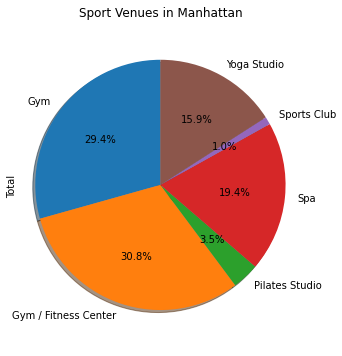

In [180]:
# autopct create %, start angle represent starting point

tot1['Total'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° ()
                            shadow=True,       # add shadow      
                            )

plt.title('Sport Venues in Manhattan')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

## 3.2 Create Dataframe

In [141]:
df_mrg=df_fin.join(Group_1, on='Neighborhood')
df_mrg['Key'] = df_mrg['Population'] / df_mrg['Sum']
df_mrg['Key1']=df_mrg['Population'] / df_mrg['Yoga Studio']
df_mrg=df_mrg.set_index('Neighborhood')
df_mrg['Key1'].replace({np.inf:0}, inplace=True)
df_mrg

,Median Income,Population,Gym,Gym / Fitness Center,Pilates Studio,Spa,Sports Club,Yoga Studio,Sum,Key,Key1
Neighborhood,,,,,,,,,,,
Battery Park City,21638,10970,4.0,0.0,0.0,0.0,0.0,0.0,4.0,2742.500000,0.000000
Carnegie Hill,122969,45225,3.0,1.0,0.0,0.0,0.0,3.0,7.0,6460.714286,15075.000000
Central Harlem,29059,116345,1.0,2.0,0.0,1.0,0.0,0.0,4.0,29086.250000,0.000000
Chelsea,115556,48108,1.0,0.0,0.0,0.0,0.0,0.0,1.0,48108.000000,0.000000
Chinatown,75086,12874,0.0,0.0,0.0,3.0,1.0,1.0,5.0,2574.800000,12874.000000
Civic Center,159882,5974,2.0,6.0,0.0,5.0,0.0,3.0,16.0,373.375000,1991.333333
Clinton,103792,46648,3.0,5.0,0.0,3.0,0.0,0.0,11.0,4240.727273,0.000000
East Harlem,33720,95589,1.0,0.0,0.0,2.0,0.0,0.0,3.0,31863.000000,0.000000
East Village,90939,65101,0.0,1.0,0.0,1.0,0.0,0.0,2.0,32550.500000,0.000000


### 3.3 Calculate KPI's

Further KPI to assess the data (population per sport venue)

In [261]:
#Lincoln Square, Manhattanville is part of Upper West Side

#Change NaN to 0
df_mrg = df_mrg.fillna(0)


df_mrg['Key1'] = np.where((df_mrg['Key1'] == 0), #Identifies the case to apply to
                           df_mrg['Population'],      #This is the value that is inserted
                           df_mrg['Key1'])

df_mrg['Key'] = np.where((df_mrg['Key'] == 0), #Identifies the case to apply to
                           df_mrg['Population'],      #This is the value that is inserted
                           df_mrg['Key'])  
 
#df_mrg.to_excel("ngbh_mrgd.xlsx")  
df_mrg

,Median Income,Population,Gym,Gym / Fitness Center,Pilates Studio,Spa,Sports Club,Yoga Studio,Sum,Key,Key1
Neighborhood,,,,,,,,,,,
Battery Park City,21638,10970,4.0,0.0,0.0,0.0,0.0,0.0,4.0,2742.500000,10970.000000
Carnegie Hill,122969,45225,3.0,1.0,0.0,0.0,0.0,3.0,7.0,6460.714286,15075.000000
Central Harlem,29059,116345,1.0,2.0,0.0,1.0,0.0,0.0,4.0,29086.250000,116345.000000
Chelsea,115556,48108,1.0,0.0,0.0,0.0,0.0,0.0,1.0,48108.000000,48108.000000
Chinatown,75086,12874,0.0,0.0,0.0,3.0,1.0,1.0,5.0,2574.800000,12874.000000
Civic Center,159882,5974,2.0,6.0,0.0,5.0,0.0,3.0,16.0,373.375000,1991.333333
Clinton,103792,46648,3.0,5.0,0.0,3.0,0.0,0.0,11.0,4240.727273,46648.000000
East Harlem,33720,95589,1.0,0.0,0.0,2.0,0.0,0.0,3.0,31863.000000,95589.000000
East Village,90939,65101,0.0,1.0,0.0,1.0,0.0,0.0,2.0,32550.500000,65101.000000


### 3.4 Overview Sport Venues per Neighborhood

<module 'matplotlib.pyplot' from '/Users/christophkring/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

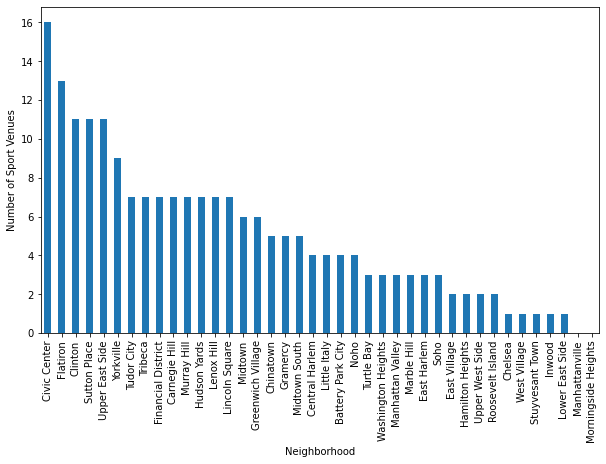

In [235]:
df_mr=df_mrg['Sum'].sort_values(ascending=False)

ax = df_mr.plot(kind='bar', figsize=(10, 6))
ax.set_xlabel("Neighborhood")
ax.set_ylabel("Number of Sport Venues")
plt

### 3. 5 Population per Neighborhood

<module 'matplotlib.pyplot' from '/Users/christophkring/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

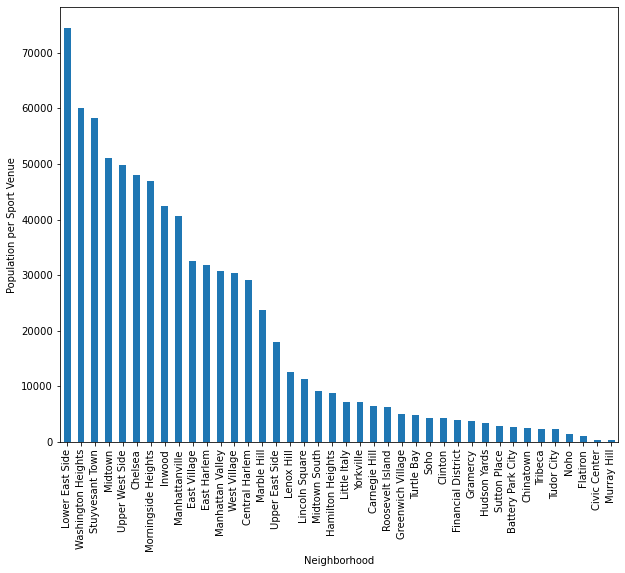

In [236]:
df_mr=df_mrg['Key'].sort_values(ascending=False)

ax=df_mr.plot(kind='bar', figsize=(10, 8))
ax.set_xlabel("Neighborhood")
ax.set_ylabel("Population per Sport Venue")
plt

### 3.6 Overview on Median Income in a Neighborhood


<module 'matplotlib.pyplot' from '/Users/christophkring/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

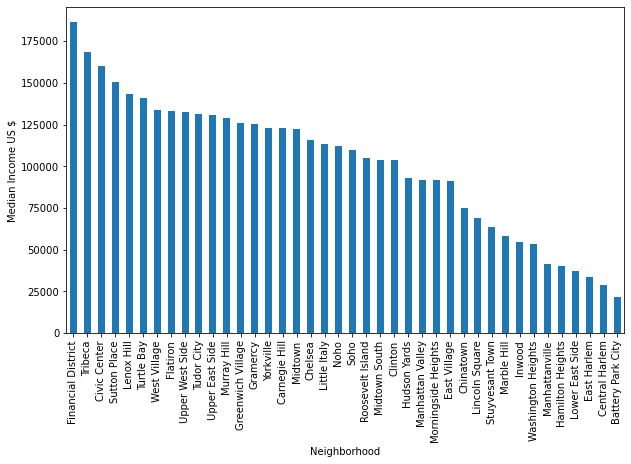

In [237]:
df_mr=df_mrg['Median Income'].sort_values(ascending=False)

ax = df_mr.plot(kind='bar', figsize=(10, 6))
ax.set_xlabel("Neighborhood")
ax.set_ylabel("Median Income US $")
plt

# 4. Data Analysis

## 4.1 Regression Analysis
The correlation of the different feature are analyzed here

Text(0, 0.5, 'Sum of Sport Venues')

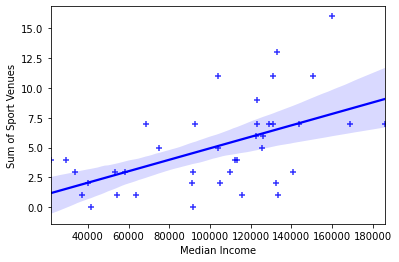

In [264]:
import seaborn as sns
ax = sns.regplot(x='Median Income', y='Sum', data=df_mrg, color='blue', marker='+')
ax.set_ylabel("Sum of Sport Venues")

Text(0, 0.5, 'Sum of Sport Venues')

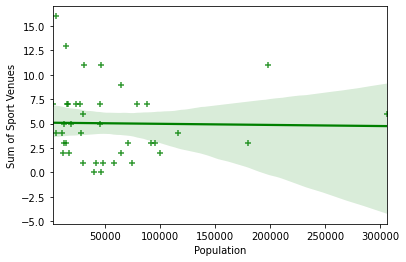

In [239]:

import seaborn as sns
ax = sns.regplot(x='Population', y='Sum', data=df_mrg, color='green', marker='+')
ax.set_ylabel("Sum of Sport Venues")


## 4.2 Bubble Plot

In [240]:
# Normalize Number of Venues
norm_sum = (df_mrg['Sum'] - df_mrg['Sum'].min()) / (df_mrg['Sum'].max() - df_mrg['Sum'].min())

Text(0.5, 1.0, 'Bubble plot Number of  Sport Venues')

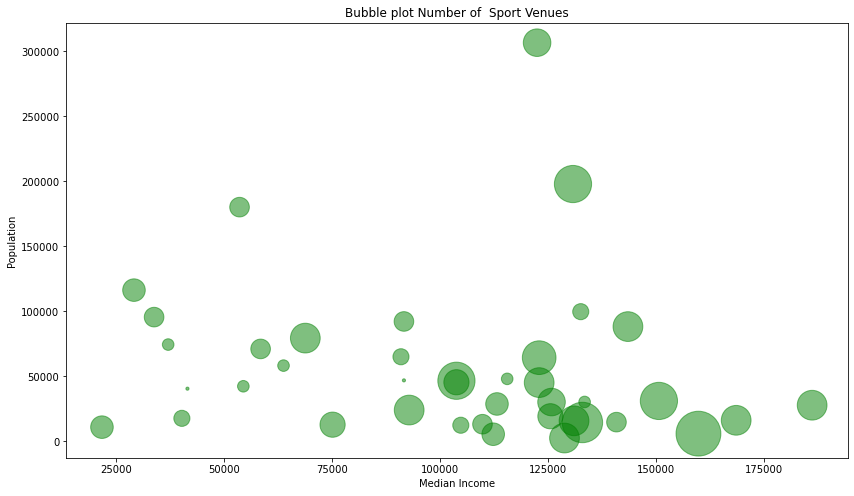

In [241]:
ax0 = df_mrg.plot(kind='scatter',
                    x='Median Income',
                    y='Population',
                    figsize=(14, 8),
                    alpha=0.5,                  # transparency
                    color='green',
                    s=norm_sum * 2000 + 10)  # pass in weights 
                    
#ax0.set_ylabel('Population')
#ax0.set_xlabel('Median Income')                        
ax0.set_title('Bubble plot Number of  Sport Venues')

In [242]:
# Normalize Population
norm_pop = (df_mrg['Population'] - df_mrg['Population'].min()) / (df_mrg['Population'].max() - df_mrg['Population'].min())

Text(0.5, 1.0, 'Bubble plot Population')

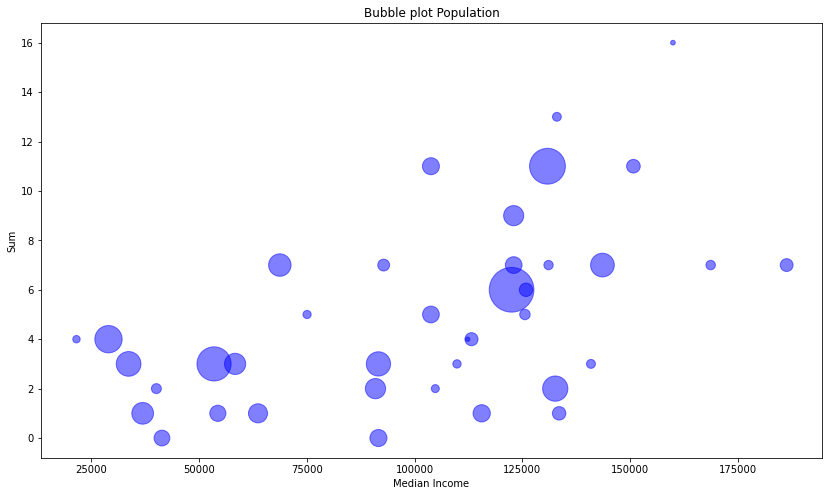

In [243]:
ax0 = df_mrg.plot(kind='scatter',
                    x='Median Income',
                    y='Sum',
                    figsize=(14, 8),
                    alpha=0.5,                  # transparency
                    color='blue',
                    s=norm_pop * 2000)  # pass in weights 
                    
#ax0.set_ylabel('Population')
#ax0.set_xlabel('Median Income')                        
ax0.set_title('Bubble plot Population')

# 5. Map of Manhattan 

## 5.1 Map of Manhattan with all sport venues

In [244]:
# create map of Manhattan using latitude and longitude values
map_yoga = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Group['Venue Latitude'], Group['Venue Longitude'], Group['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_yoga)  

map_yoga

## 5.2 Clustering


### Create dataset for Clusterting

We are trying to find a cluster to explain the dataset. The data set is separated into test and trainset to find the best k-value

In [245]:
from sklearn import preprocessing
new=df_mrg[['Population','Median Income','Yoga Studio','Sum']]
new.fillna(0,inplace=True)
new.reset_index(inplace=True)

new

/Users/christophkring/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,Neighborhood,Population,Median Income,Yoga Studio,Sum
0,Battery Park City,10970,21638,0.0,4.0
1,Carnegie Hill,45225,122969,3.0,7.0
2,Central Harlem,116345,29059,0.0,4.0
3,Chelsea,48108,115556,0.0,1.0
4,Chinatown,12874,75086,1.0,5.0
5,Civic Center,5974,159882,3.0,16.0
6,Clinton,46648,103792,0.0,11.0
7,East Harlem,95589,33720,0.0,3.0
8,East Village,65101,90939,0.0,2.0
9,Financial District,27834,186231,0.0,7.0


In [246]:
from sklearn.preprocessing import StandardScaler


In [247]:
X = new[['Population','Median Income','Sum']].values  #.astype(float)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-0.76263505, -1.95433529, -0.27975434],
       [-0.18245872,  0.52017113,  0.53903884],
       [ 1.02209946, -1.77311422, -0.27975434],
       [-0.1336294 ,  0.33914543, -1.09854752],
       [-0.73038704, -0.64913333, -0.00682328],
       [-0.84725222,  1.42158783,  2.99541839],
       [-0.1583574 ,  0.05186815,  1.63076309],
       [ 0.67055546, -1.65929244, -0.5526854 ],
       [ 0.15418074, -0.26200254, -0.82561646],
       [-0.47700978,  2.0650313 ,  0.53903884],
       [-0.70183129,  0.76483545,  2.17662521],
       [-0.62083864,  0.58378532, -0.00682328],
       [-0.43553111,  0.59006127,  0.26610778],
       [-0.647887  , -1.502003  , -0.82561646],
       [-0.53996455, -0.21558006,  0.53903884],
       [-0.23032264, -1.15413963, -1.09854752],
       [ 0.54720341,  1.02251564,  0.53903884],
       [ 0.39710788, -0.80337026,  0.53903884],
       [-0.4606656 ,  0.28139205, -0.27975434],
       [ 0.31301576, -1.57963429, -1.09854752],
       [-0.26133425, -1.47045232, -1.371

In [248]:
X = new[['Population','Median Income','Sum']].values  #.astype(float)
y = new[['Yoga Studio']].values
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (32, 3) (32, 1)
Test set: (8, 3) (8, 1)


In [249]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
%matplotlib inline

Ks = 12
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

<ipython-input-249-e0315a3c9bd5>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
<ipython-input-249-e0315a3c9bd5>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
<ipython-input-249-e0315a3c9bd5>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
<ipython-input-249-e0315a3c9bd5>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  neigh = KNeighborsC

array([0.25 , 0.5  , 0.375, 0.375, 0.375, 0.375, 0.625, 0.5  , 0.5  ,
       0.5  , 0.5  ])

### 5.2.1 Training the algorythm




Here the optimum k value is calculated and displayed in diagramm. It is clearly to see that the optimum k is 7!

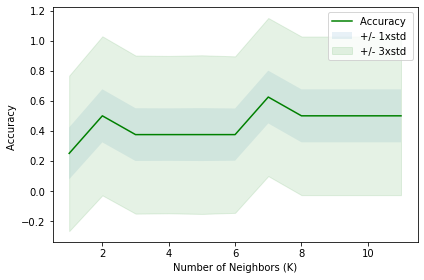

In [250]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [251]:
# set number of clusters
kclusters = 7

#manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 4, 3, 3, 5, 1, 4, 3, 1], dtype=int32)

The cluster labels are calculated and will be joined with the original dataframe

In [262]:
# add clustering labels
manhattan_data.drop(columns=['Cluster Labels'], inplace=True)
manhattan_data.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(new.set_index('Neighborhood'), on='Neighborhood')
#manhattan_merged.to_excel("cluster.xlsx")  
manhattan_merged.head() # check the last columns!

,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,Population,Median Income,Yoga Studio,Sum
0,2,Manhattan,Marble Hill,40.876551,-73.910660,71132,58408,1.0,3.0
1,1,Manhattan,Chinatown,40.715618,-73.994279,12874,75086,1.0,5.0
2,4,Manhattan,Washington Heights,40.851903,-73.936900,180158,53525,0.0,3.0
3,3,Manhattan,Inwood,40.867684,-73.921210,42399,54406,1.0,1.0
4,3,Manhattan,Hamilton Heights,40.823604,-73.949688,17745,40161,2.0,2.0


### 5.2.2 Show cluster in Folium Map

In [263]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

### 5.2.3 Examine cluster

In [254]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[2] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Population,Median Income,Yoga Studio,Sum
35,Turtle Bay,14827,140882,0.0,3.0


In [255]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[2] + list(range(5, manhattan_merged.shape[1]))]]


,Neighborhood,Population,Median Income,Yoga Studio,Sum
1,Chinatown,12874,75086,1.0,5.0
6,Central Harlem,116345,29059,0.0,4.0
9,Yorkville,64404,122969,0.0,9.0
11,Roosevelt Island,12440,104808,0.0,2.0
12,Upper West Side,99773,132605,0.0,2.0
14,Clinton,46648,103792,0.0,11.0
16,Murray Hill,2599,128836,1.0,7.0
26,Morningside Heights,46942,91624,0.0,0.0
31,Noho,5532,112314,2.0,4.0
32,Civic Center,5974,159882,3.0,16.0


In [256]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[2] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Population,Median Income,Yoga Studio,Sum
0,Marble Hill,71132,58408,1.0,3.0
13,Lincoln Square,79444,68770,1.0,7.0
15,Midtown,306638,122484,0.0,6.0
19,East Village,65101,90939,0.0,2.0
20,Lower East Side,74479,36982,1.0,1.0
22,Little Italy,28799,113191,1.0,4.0
30,Carnegie Hill,45225,122969,3.0,7.0


In [257]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[2] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Population,Median Income,Yoga Studio,Sum
3,Inwood,42399,54406,1.0,1.0
4,Hamilton Heights,17745,40161,2.0,2.0
8,Upper East Side,197935,130804,3.0,11.0
18,Greenwich Village,30283,125831,1.0,6.0
21,Tribeca,16236,168627,1.0,7.0
24,West Village,30344,133501,0.0,1.0
25,Manhattan Valley,92251,91624,2.0,3.0
27,Gramercy,19342,125574,1.0,5.0
28,Battery Park City,10970,21638,0.0,4.0
29,Financial District,27834,186231,0.0,7.0


In [258]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[2] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Population,Median Income,Yoga Studio,Sum
2,Washington Heights,180158,53525,0.0,3.0
7,East Harlem,95589,33720,0.0,3.0
17,Chelsea,48108,115556,0.0,1.0
37,Stuyvesant Town,58293,63717,0.0,1.0


In [259]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 5, manhattan_merged.columns[[2] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Population,Median Income,Yoga Studio,Sum
5,Manhattanville,40568,41453,0.0,0.0
10,Lenox Hill,88306,143540,0.0,7.0


In [260]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 6, manhattan_merged.columns[[2] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Population,Median Income,Yoga Studio,Sum
23,Soho,13224,109829,1.0,3.0


# Finished